In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('air_quality.csv', sep=';', decimal=',', header=0)
df = df.drop(columns = ['Unnamed: 15', 'Unnamed: 16']).dropna().replace(-200, np.nan)
df.isna().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

Date and time columns does not have any missing values, whereas the column NMHC(GT) has too many missing values and it should be dropped

In [5]:
df = df.drop(columns = ['Date', 'Time', 'NMHC(GT)'])

In [6]:
for i, col in enumerate(df.columns):
  df[col] = df[col].fillna(df[col].mean())
df.isna().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

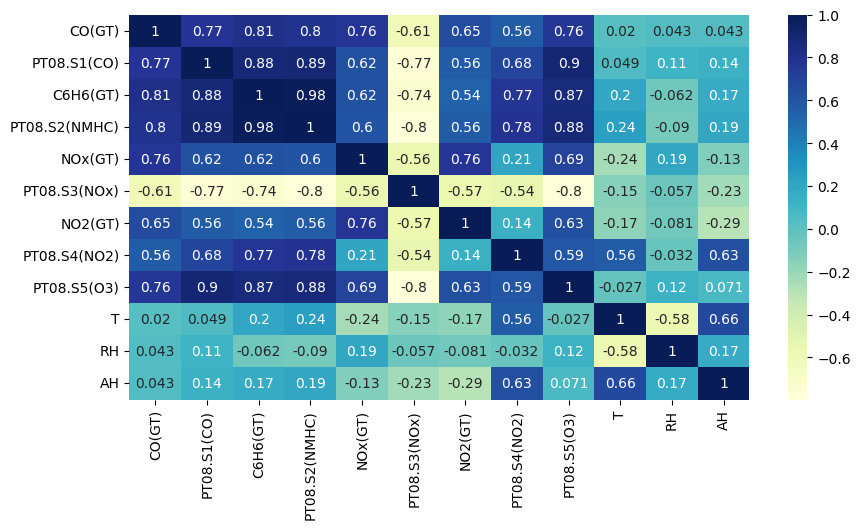

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
plt.show()

In [8]:
df = df.drop(columns = ['T', 'RH', 'AH'])
df

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0
...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0


In [9]:
# X = df.drop(columns = ['C6H6(GT)'])
# y = df['C6H6(GT)']
X = df.drop(columns = ['CO(GT)'])
y = df['CO(GT)']
# Here I have considered both variables to be target. For C6H6, R2_Score was higher, but still it was more helpful and right to choose CO concentration for prediciton target.
# For C6H6 I got 0.0113 MSE, which is expected because its values range is not large enough.

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

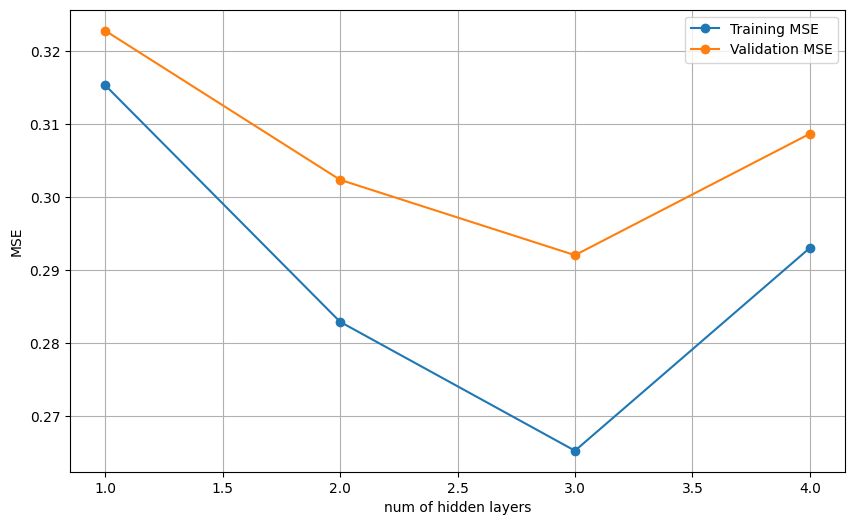

In [11]:
hidden_layer_sizes = [(10,), (10, 10), (10, 10, 10), (10, 10, 10, 10)]  # [1, 2, 3, 4]
params1 = { 'hidden_layer_sizes': hidden_layer_sizes } #others are default for task 1 (activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant')

mlp = MLPRegressor(max_iter=1000, random_state=42) #
grid_search_layers = GridSearchCV(mlp, params1, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_layers.fit(X_train, y_train)
cv_results = pd.DataFrame(grid_search_layers.cv_results_)
hidden_layers = [1, 2, 3, 4]

plt.figure(figsize=(10, 6))
plt.plot(hidden_layers, -cv_results['mean_train_score'], label='Training MSE', marker='o')
plt.plot(hidden_layers, -cv_results['mean_test_score'], label='Validation MSE', marker='o')
plt.xlabel('num of hidden layers')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
best_hidden_layers = grid_search_layers.best_params_['hidden_layer_sizes']
print(f"Best number of hidden layers: {best_hidden_layers}")

Best number of hidden layers: (10, 10, 10)


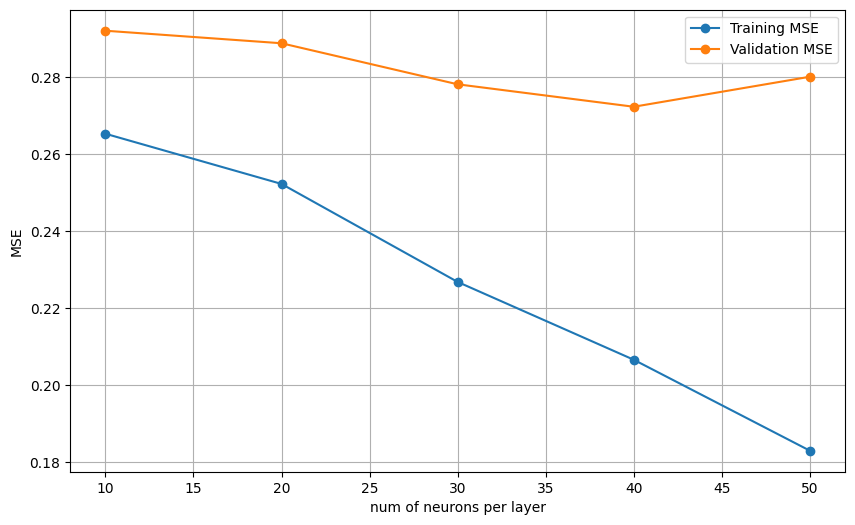

In [13]:
neuron_sizes = [(n,) * 3 for n in [10, 20, 30, 40, 50]] # 3 because best param for first task was 3 layers
params2 = { 'hidden_layer_sizes': neuron_sizes } # for task 1 we have set only 1- neurons for each layer, now we will use 5 sets of neuron sizes

grid_search_neurons = GridSearchCV(mlp, params2, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_neurons.fit(X_train, y_train)

cv_results_neurons = pd.DataFrame(grid_search_neurons.cv_results_)
neurons_per_layer = [10, 20, 30, 40, 50]

plt.figure(figsize=(10, 6))
plt.plot(neurons_per_layer, -cv_results_neurons['mean_train_score'], label='Training MSE', marker='o')
plt.plot(neurons_per_layer, -cv_results_neurons['mean_test_score'], label='Validation MSE', marker='o')
plt.xlabel('num of neurons per layer')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
grid_search_neurons.best_params_['hidden_layer_sizes']

(40, 40, 40)

In [15]:
optimal_model = MLPRegressor(hidden_layer_sizes=grid_search_neurons.best_params_['hidden_layer_sizes'], max_iter=1000, random_state=42)
optimal_model.fit(X_train, y_train)
y_pred = optimal_model.predict(X_test)
print(f"Test MSE with best configuration: {mean_squared_error(y_test, y_pred)}")

Test MSE with best configuration: 0.259964353556613


Assuming CO values range from min=0.1 to max 12, that MSE is quite reasonable ad indicates good model performance.

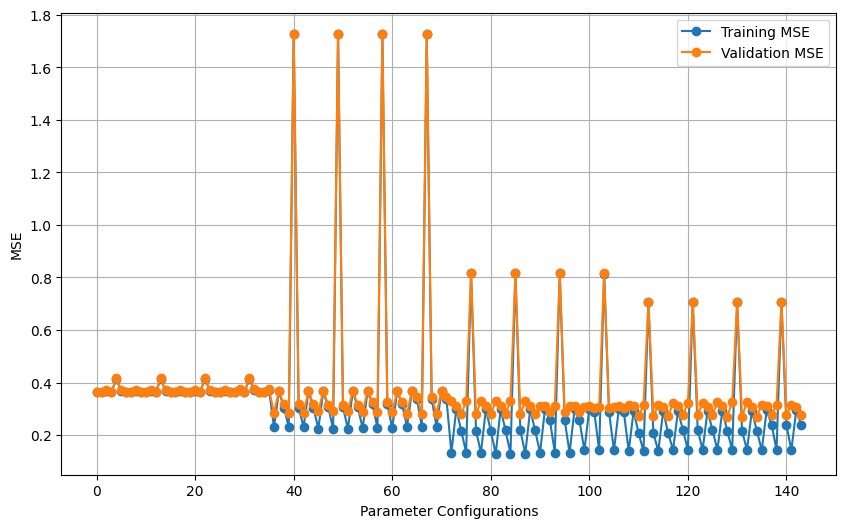

Best parameters after additional tuning: {'activation': 'relu', 'alpha': 0.01, 'learning_rate': 'constant', 'solver': 'adam'}
Test MSE with best configuration from Lab 8: 0.2513171910926743
Improvement in MSE compared to Lab 7: -0.008647162463938707


In [16]:
params3 = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

mlp_best_layers = MLPRegressor(hidden_layer_sizes=grid_search_neurons.best_params_['hidden_layer_sizes'], max_iter=1000, random_state=42)
grid_search_final = GridSearchCV(mlp_best_layers, params3, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search_final.fit(X_train, y_train)
cv_results_final = pd.DataFrame(grid_search_final.cv_results_)

plt.figure(figsize=(10, 6))
plt.plot(-cv_results_final['mean_train_score'], label='Training MSE', marker='o')
plt.plot(-cv_results_final['mean_test_score'], label='Validation MSE', marker='o')
plt.xlabel('Parameter Configurations')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

print(f"Best parameters after additional tuning: {grid_search_final.best_params_}")
optimal_model_final = MLPRegressor(hidden_layer_sizes=grid_search_neurons.best_params_['hidden_layer_sizes'], **grid_search_final.best_params_, max_iter=1000, random_state=42)
optimal_model_final.fit(X_train, y_train)
y_pred_final = optimal_model_final.predict(X_test)

final_mse = mean_squared_error(y_test, y_pred_final)

In [19]:
print(f"Test MSE with best params: {final_mse}")
print(f"Improvement: +{(mean_squared_error(y_test, y_pred) - final_mse) * 100:.2f}%")

Test MSE with best params: 0.2513171910926743
Improvement: +0.86%


The model may have already reached a saturation point in its learning ability after optimizing the hidden layers. At this stage, additional fine-tuning of parameters such as alpha, learning_rate, or solver might not drastically change the performance. These parameters tend to have more impact when the model is underfitting or overfitting, which may not have been the case here.

Also, I think, this modest improvement shows that the additional hyperparameter tuning slightly fine-tuned the generalization of the model without pushing it into overfitting